In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from wildwood.forest import ForestClassifier

# n_samples = 1000
n_samples = 1_000_000
# n_samples = int(5e5)
# n_samples = 10

data_random_state = 123

X_train, y_train = make_moons(
    n_samples=n_samples, noise=0.2, random_state=data_random_state
)

h = 0.2
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

X_test = np.empty((xx.ravel().shape[0], 2))
X_test[:, 0] = xx.ravel()
X_test[:, 1] = yy.ravel()

In [2]:
from sklearn.ensemble._hist_gradient_boosting.binning import _BinMapper

bin_mapper = _BinMapper(subsample=None)
bin_mapper.fit(X_train, y_train)
X_train_binned1 = bin_mapper.transform(X_train)
X_test_binned1 = bin_mapper.transform(X_test)

In [15]:
from wildwood.preprocessing import Encoder, features_bitarray_to_array

encoder = Encoder()
encoder = encoder.fit(X_train, y_train)
X_train_bitarray = encoder.transform(X_train)
X_test_bitarray = encoder.transform(X_test)

X_train_binned2 = features_bitarray_to_array(X_train_bitarray)
X_test_binned2 = features_bitarray_to_array(X_test_bitarray)

# - Comparer les temps de calcul
# - Verifier qu'on arrive exactement aux meme resultats

In [16]:
X_train_bitarray
X_train_bitarray.max_values



array([255, 255], dtype=uint64)

In [4]:
# bin_mapper.bin_thresholds_[0].shape

# bin_mapper[0]
bin_mapper.bin_thresholds_[0].shape

(254,)

In [5]:
# Test binning thresholds

n_features = X_train.shape[1]

for j in range(n_features):
    np.testing.assert_array_equal(
        bin_mapper.bin_thresholds_[j],
        encoder.binning_thresholds_[j]
    )

In [6]:
np.testing.assert_array_equal(X_train_binned1, X_train_binned2)
np.testing.assert_array_equal(X_test_binned1, X_test_binned2)

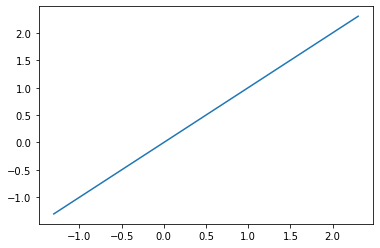

In [7]:
plt.plot(bin_mapper.bin_thresholds_[0], encoder.binning_thresholds_[0])

In [8]:
encoder.binning_thresholds_[0].shape

(254,)

In [9]:
random_state = 42

clf_kwargs = {
    "n_estimators": 1,
    "max_features": 2,
    "min_samples_split": 2,
    "random_state": random_state,
    "n_jobs": -1,
    "dirichlet": 1e-8,
    "step": 1.0,
    "aggregation": True,
    "verbose": True,
}

clf = ForestClassifier(**clf_kwargs)

# from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
# clf = HistGradientBoostingClassifier()
# clf = RandomForestClassifier(n_jobs=-1)


clf.fit(X_train, y_train)
Z = clf.predict_proba(X_test)[:, 1]

/Users/stephane/Code/wildwood/wildwood/preprocessing/_checks.py:275: UserWarning: I will consider column 0 as numerical.
  warnings.warn(f"I will consider column {col_idx} as numerical.")
/Users/stephane/Code/wildwood/wildwood/preprocessing/_checks.py:275: UserWarning: I will consider column 1 as numerical.
  warnings.warn(f"I will consider column {col_idx} as numerical.")


ValueError: cannot assign slice from input of different size

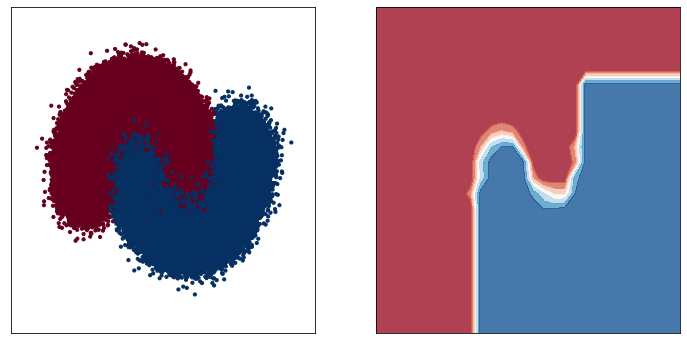

In [27]:
fig = plt.figure(figsize=(12, 6))
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

ax = plt.subplot(1, 2, 1)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=cm)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

ax = plt.subplot(1, 2, 2)
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

plt.show()